Computed TE (Expected Times) for Activities:
Activity    TE
   10-20  10.0
   10-30   9.0
   30-40   8.0
   20-40   9.0
   20-50   7.0
   30-50   5.0
   40-50  11.0

Critical Path: ['10', '20', '40', '50'] with duration 30.00


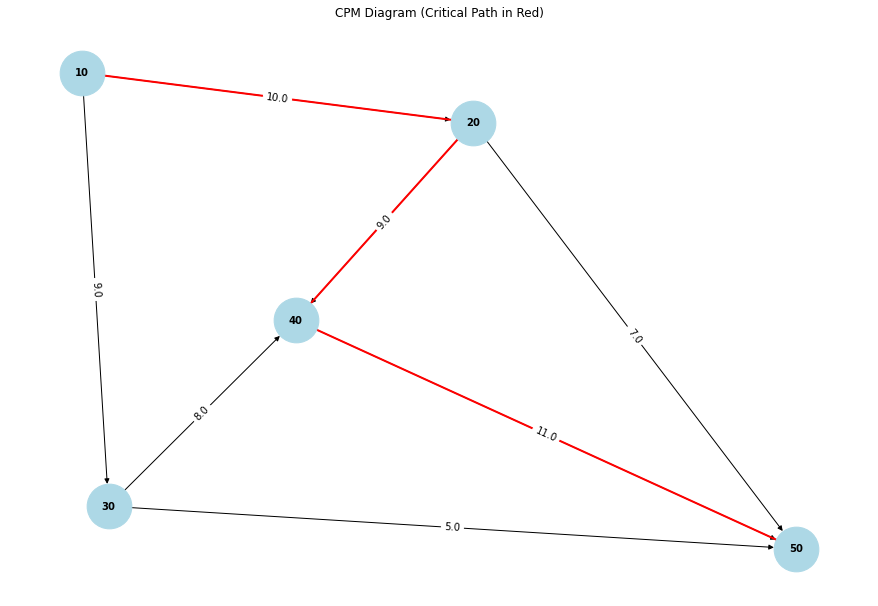


Probability of completing the project within 35 days:
Z-Score: 1.07
Probability: 85.68%


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.stats import norm

# Create an empty directed graph
def create_graph():
    return nx.DiGraph()

# Add an event and its dependencies to the graph
def add_event(graph, task, dependencies={}):
    if task not in graph:
        graph.add_node(task)
    for dep, duration in dependencies.items():
        if dep not in graph:
            graph.add_node(dep)
        graph.add_edge(dep, task, weight=duration)

# Dynamically build a graph from event data
def create_dynamic_events(event_data):
    graph = create_graph()
    for event, dependencies in event_data.items():
        add_event(graph, event, dependencies)
    return graph

# Find the critical path and its total duration
def find_critical_path(graph):
    critical_path = nx.dag_longest_path(graph, weight='weight')
    critical_path_length = nx.dag_longest_path_length(graph, weight='weight')
    return critical_path, critical_path_length

# Visualize the graph and highlight the critical path
def visualize_graph(graph):
    pos = nx.spring_layout(graph, seed=42)
    plt.figure(figsize=(12, 8))
    nx.draw(graph, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold')
    edge_labels = {(u, v): f'{d["weight"]:.1f}' for u, v, d in graph.edges(data=True)}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    critical_path, _ = find_critical_path(graph)
    nx.draw_networkx_edges(graph, pos, edgelist=list(zip(critical_path, critical_path[1:])), edge_color='red', width=2)
    plt.title("CPM Diagram (Critical Path in Red)")
    plt.show()

# Compute TE using the correct PERT formula: TE = (to + 4*tl + tp) / 6
def compute_te(activities):
    data = []
    variances = {}
    for activity, to, tl, tp in activities:
        te = (to + 4 * tl + tp) / 6
        variance = ((tp - to) / 6) ** 2
        data.append({'Activity': activity, 'TE': te})
        variances[activity] = variance
    return pd.DataFrame(data), variances

# ---- Main Program ----

# Step 0: Input data (activity, optimistic, most likely, pessimistic)
activity_te_data = [
    ("10-20", 6, 9, 18),
    ("10-30", 5, 8, 17),
    ("30-40", 4, 7, 16),
    ("20-40", 4, 7, 22),
    ("20-50", 4, 7, 10),
    ("30-50", 2, 5, 8),
    ("40-50", 4, 10, 22)
]

# Step 1: Compute TE and variance
df_te, variances = compute_te(activity_te_data)
print("Computed TE (Expected Times) for Activities:")
print(df_te.to_string(index=False))

# Step 2: Convert TE data into event dependency format
event_data_from_te = {}
for row in df_te.itertuples():
    start, end = row.Activity.split('-')
    if end not in event_data_from_te:
        event_data_from_te[end] = {}
    event_data_from_te[end][start] = row.TE

# Step 3: Create project graph
graph = create_dynamic_events(event_data_from_te)

# Step 4: Find and display critical path
critical_path, length = find_critical_path(graph)
print(f"\nCritical Path: {critical_path} with duration {length:.2f}")

# Step 5: Visualize graph
visualize_graph(graph)

# Step 6: Calculate project variance and standard deviation
critical_activities = [f"{critical_path[i]}-{critical_path[i+1]}" for i in range(len(critical_path)-1)]
critical_variance = sum(variances.get(activity, 0) for activity in critical_activities)
project_std_dev = math.sqrt(critical_variance)

# Step 7: Compute probability of finishing within 35 days
target_duration = 35
z_score = (target_duration - length) / project_std_dev
probability = norm.cdf(z_score)

# Step 8: Display probability results
print(f"\nProbability of completing the project within {target_duration} days:")
print(f"Z-Score: {z_score:.2f}")
print(f"Probability: {probability:.2%}")
